# Amazon Reviews Dataset

This dataset contains several million reviews of Amazon products, with the reviews separated into two classes for positive and negative reviews. The two classes are evenly balanced here.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

In [7]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
data = pd.read_fwf("./input/train.ft.txt",header= None)
data.head()

['test.ft.txt', 'train.ft.txt']


,0,1,2
0,__label__2,Stuning even for the non-gamer: This sound tra...,NaN
1,__label__2,The best soundtrack ever to anything.: I'm rea...,NaN
2,__label__2,Amazing!: This soundtrack is my favorite music...,NaN
3,__label__2,Excellent Soundtrack: I truly like this soundt...,NaN
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He...",NaN


In [34]:
data.drop(data.columns[[2]], axis = 1, inplace = True)
print(data)

                  0                                                  1
0        __label__2  Stuning even for the non-gamer: This sound tra...
1        __label__2  The best soundtrack ever to anything.: I'm rea...
2        __label__2  Amazing!: This soundtrack is my favorite music...
3        __label__2  Excellent Soundtrack: I truly like this soundt...
4        __label__2  Remember, Pull Your Jaw Off The Floor After He...
...             ...                                                ...
3599995  __label__1  Don't do it!!: The high chair looks great when...
3599996  __label__1  Looks nice, low functionality: I have used thi...
3599997  __label__1  compact, but hard to clean: We have a small ho...
3599998  __label__1  what is it saying?: not sure what this book is...
3599999  __label__2  Makes My Blood Run Red-White-And-Blue: I agree...

[3600000 rows x 2 columns]


# Reading the text

The text is held in a compressed format. Luckily, we can still read it line by line. The first word gives the label, so we have to convert that into a number and then take the rest to be the comment.

In [11]:
import bz2

def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('./input/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('./input/test.ft.txt.bz2')

In [36]:
train_labels

array([1, 0, 1, ..., 1, 1, 1])

In [43]:
len(train_labels)

2880000

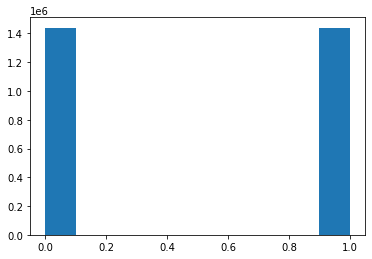

In [40]:
plt.hist(train_labels)
plt.show()

In [13]:
train_texts

['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'Amazing!: This soundtrack is my favorite music of all

In [35]:
test_labels

array([1, 1, 0, ..., 0, 1, 0])

In [42]:
len(test_labels)

400000

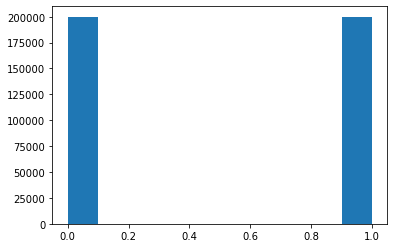

In [41]:
plt.hist(test_labels)
plt.show()

In [15]:
test_texts

['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"',
 "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of s

# Text Preprocessing

The first thing I'm going to do to process the text is to lowercase everything and then remove non-word characters. I replace these with spaces since most are going to be punctuation. Then I'm going to just remove any other characters (like letters with accents). It could be better to replace some of these with regular ascii characters but I'm just going to ignore that here. It also turns out if you look at the counts of the different characters that there are very few unusual characters in this corpus.

In [18]:
import re
NON_ALPHANUM = re.compile(r'[\W]')  #W = !(a-zA-Z0-9_)
NON_ASCII = re.compile(r'[^a-z0-1\s]')

def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [19]:
train_texts

['stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    ',
 'the best soundtrack ever to anything   i m reading a lot of reviews saying that this is the best  game soundtrack  and i figured that i d write a review to disagree a bit  this in my opinino is yasunori mitsuda s ultimate masterpiece  the music is timeless and i m been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say  but if you are going to buy any cd for this much money  this is the only one that i feel would be worth every penny ',
 'amazing   this soundtrack is my favorite music of all 

In [20]:
test_texts

['great cd  my lovely pat has one of the great voices of her generation  i have listened to this cd for years and i still love it  when i m in a good mood it makes me feel better  a bad mood just evaporates like sugar in the rain  this cd just oozes life  vocals are jusat stuunning and lyrics just kill  one of life s hidden gems  this is a desert isle cd in my book  why she never made it big is just beyond me  everytime i play this  no matter black  white  young  old  male  female everybody says one thing  who was that singing   ',
 'one of the best game music soundtracks   for a game i didn t really play  despite the fact that i have only played a small portion of the game  the music i heard  plus the connection to chrono trigger which was great as well  led me to purchase the soundtrack  and it remains one of my favorite albums  there is an incredible mix of fun  epic  and emotional songs  those sad and beautiful tracks i especially like  as there s not too many of those kinds of son

# Train/Validation Split

Now I'm going to set aside 20% of the training set for validation.

In [21]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, random_state=57643892, test_size=0.2)

Keras provides some tools for converting text to formats that are useful in learning models. I've already done some processing, so now I will just run a Tokenizer using the top 12000 words as features.

In [24]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [26]:
train_texts

array([[   0,    0,    0, ...,   12,   17,  181],
       [   0,    0,    0, ...,    7,    1,  147],
       [   0,    0,    0, ...,  141,    8,  172],
       ...,
       [   0,    0,    0, ...,    1,  807,  798],
       [   0,    0,    0, ...,    4,  179,   52],
       [   0,    0,    0, ...,    7,    4, 2380]])

In [27]:
val_texts

array([[   0,    0,    0, ...,   67,  125,  335],
       [   0,    0,    0, ...,   53,    6,  830],
       [   0,    0,    0, ...,    6,    9,  355],
       ...,
       [   0,    0,    0, ..., 2141,    8,  775],
       [   0,    0,    0, ...,  294,   20,  134],
       [   0,    0,    0, ...,   86,  895, 6936]])

In [28]:
test_texts

array([[   0,    0,    0, ...,   14,   12,  908],
       [   0,    0,    0, ...,  368,  163,    6],
       [   0,    0,    0, ...,   94, 3795,  437],
       ...,
       [   0,    0,    0, ..., 1593,   11,  442],
       [   0,    0,    0, ..., 3073,    5,   52],
       [   0,    0,    0, ...,    5,  203, 1333]])

# Padding Sequences

In order to use batches effectively, I'm going to need to take my sequences and turn them into sequences of the same length. I'm just going to make everything here the length of the longest sentence in the training set. I'm not dealing with this here, but it may be advantageous to have variable lengths so that each batch contains sentences of similar lengths. This might help mitigate issues that arise from having too many padded elements in a sequence. There are also different padding modes that might be useful for different models.

In [25]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

In [1]:
train_texts.shape

NameError: name 'train_texts' is not defined

# K Nearest Neighbours Model

In [2]:
#Load the necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

NameError: name 'neighbors' is not defined

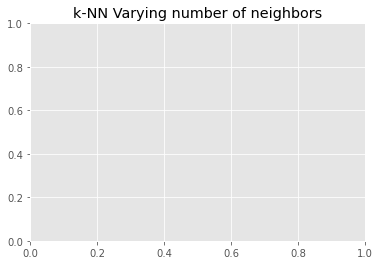

In [4]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [5]:
# We can observe above that we get maximum testing accuracy for k=7. So lets create a KNeighborsClassifier with number of
# neighbors as 7.
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=7)

NameError: name 'KNeighborsClassifier' is not defined

In [6]:
#Fit the model
knn.fit(X_train,y_train)

NameError: name 'knn' is not defined

In [7]:
#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn.score(X_test,y_test)

NameError: name 'knn' is not defined

Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. Scikit-learn provides facility to calculate confusion matrix using the confusion_matrix method.

In [8]:
#import confusion_matrix
from sklearn.metrics import confusion_matrix

In [9]:
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)

NameError: name 'knn' is not defined

In [10]:
confusion_matrix(y_test,y_pred)

NameError: name 'y_test' is not defined

Considering confusion matrix above:

True negative = 165

False positive = 36

True postive = 60

Fasle negative = 47

Confusion matrix can also be obtained using crosstab method of pandas.

In [11]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

NameError: name 'y_test' is not defined

Classification Report

Another important report is the Classification report. It is a text summary of the precision, recall, F1 score for each class. Scikit-learn provides facility to calculate Classification report using the classification_report method.

In [12]:
#import classification_report
from sklearn.metrics import classification_report

In [13]:
print(classification_report(y_test,y_pred))

NameError: name 'y_test' is not defined

ROC (Reciever Operating Charecteristic) curve

It is a plot of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.

An ROC curve demonstrates several things:

1) It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).

2) The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.

3)The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

4) The area under the curve is a measure of test accuracy.

In [14]:
y_pred_proba = knn.predict_proba(X_test)[:,1]

NameError: name 'knn' is not defined

In [15]:
from sklearn.metrics import roc_curve

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

NameError: name 'y_test' is not defined

NameError: name 'fpr' is not defined

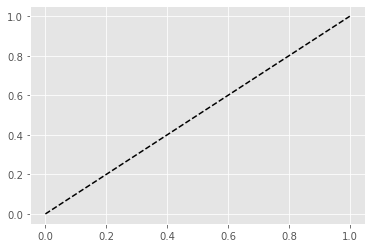

In [17]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=7) ROC curve')
plt.show()

In [18]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

NameError: name 'y_test' is not defined

Cross Validation

Now before getting into the details of Hyperparamter tuning, let us understand the concept of Cross validation.

The trained model's performance is dependent on way the data is split. It might not representative of the model’s ability to generalize.

The solution is cross validation.

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.

In k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged (or otherwise combined) to produce a single estimation. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.

Hyperparameter tuning

The value of k (i.e 7) we selected above was selected by observing the curve of accuracy vs number of neighbors. This is a primitive way of hyperparameter tuning.

There is a better way of doing it which involves:

1) Trying a bunch of different hyperparameter values

2) Fitting all of them separately

3) Checking how well each performs

4) Choosing the best performing one

5) Using cross-validation every time

Scikit-learn provides a simple way of achieving this using GridSearchCV i.e Grid Search cross-validation.



In [20]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [21]:
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}

In [22]:
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

NameError: name 'KNeighborsClassifier' is not defined

In [23]:
knn_cv.best_score_

NameError: name 'knn_cv' is not defined

In [24]:
knn_cv.best_params_

NameError: name 'knn_cv' is not defined